In [30]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

def estimate_markups_final(df):
    # Ensure ID and Year are integers and sorted correctly for the panel
    df = df.sort_values(['firm_ID', 'year']).reset_index(drop=True)
    df['firm_ID'] = df['firm_ID'].astype(int)
    df['year'] = df['year'].astype(int)
    
    # Convert Python DF to R
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(df)
    
    ro.globalenv['r_df'] = r_df
    
    # Structural Estimation in R [cite: 212, 273]
    ro.r('''
        library(prodest)
        
        # We explicitly cast ID and Year to numeric to prevent factor expansion
        # Y: logged output | fX: free inputs | sX: state input | pX: proxy input
        res <- prodestLP(
            Y = as.numeric(r_df$log_Y), 
            fX = cbind(as.numeric(r_df$log_L), as.numeric(r_df$log_M)), 
            sX = as.numeric(r_df$log_K), 
            pX = as.numeric(r_df$log_M), 
            id = as.numeric(r_df$firm_ID), 
            time = as.numeric(r_df$year)
        )
        
        # Extract estimated coefficients (betas) [cite: 323]
        betas <- as.numeric(coef(res))
    ''')
    
    # Retrieve betas back to Python
    b = ro.r('betas')
    # Order: beta_l, beta_m, beta_k
    beta_m = b[1] 
    
    # Calculate Markup: mu_it = theta_m / alpha_m [cite: 187]
    # 1. Output Elasticity (theta) is beta_m for Cobb-Douglas [cite: 197]
    # 2. Expenditure Share (alpha) [cite: 188]
    df['alpha_m'] = df['material_cost'] / df['revenue']
    df['markup'] = beta_m / df['alpha_m']
    
    return df, beta_m



In [31]:
import pandas as pd
df = pd.read_csv("production_data.csv")
len(df.industry.unique())

623

In [44]:
industry = df.industry.unique()[1]
industry

4632

In [45]:
len(df[df.industry == industry])

601

This is a good industry with many companies

In [59]:
import numpy as np
df_sample = df[df.industry == industry]
df_sample.head()
df_sample['revenue'] = np.exp(df_sample['log_Y'])
df_sample['material_cost'] = np.exp(df_sample['log_M'])

/var/folders/cg/hn5ylvtj3jsbz67fjvys2zww0000gn/T/ipykernel_6371/453634793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['revenue'] = np.exp(df_sample['log_Y'])
/var/folders/cg/hn5ylvtj3jsbz67fjvys2zww0000gn/T/ipykernel_6371/453634793.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['material_cost'] = np.exp(df_sample['log_M'])


In [60]:
df_with_markups,beta_m = estimate_markups_final(df_sample) 

In [61]:
beta_m

0.6294133160805325

There is a problem with BETA_M. It shouldn't be zero. Let's check the outliers in the dataframe

In [64]:
df_with_markups.to_csv("markups_in_meat_industry.csv", index=False)

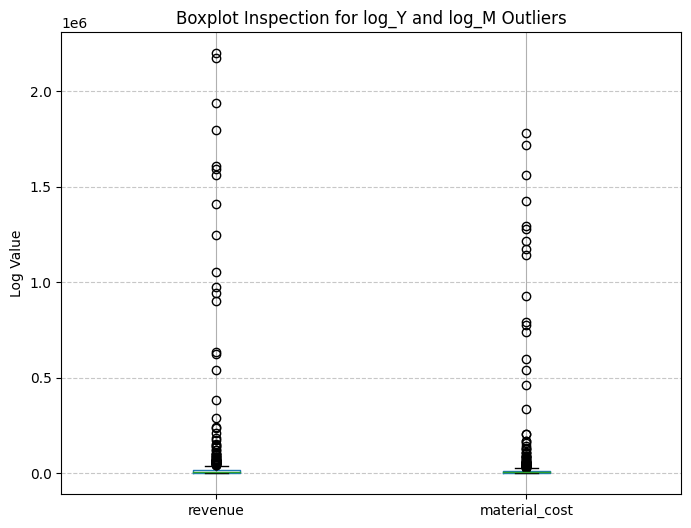

In [51]:
import matplotlib.pyplot as plt

# Selecting the columns with capital Y and M as specified
cols_to_plot = ['revenue', 'material_cost']

# Create a boxplot to visualize the distribution and outliers
# Outliers are typically shown as individual points beyond the 'whiskers'
plt.figure(figsize=(8, 6))
df_sample[cols_to_plot].boxplot()

plt.title('Boxplot Inspection for log_Y and log_M Outliers')
plt.ylabel('Log Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Use plt.show() if you are in a Jupyter Notebook/Spyder
# or plt.savefig('outliers_check.png') to save the file
plt.show()

In [53]:
df_with_markups["revenue_to_material"] = df_with_markups.revenue / df_with_markups.material_cost